In [42]:
import numpy as np
import matplotlib as mpl
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import gymnasium as gym
from matplotlib import colors
from IPython.display import clear_output
from time import sleep

In [43]:
env = gym.make("Taxi-v3")
state, info = env.reset()


def stateinfo2state(state_info):
    taxi_row = state_info[0]
    taxi_column = state_info[1]
    passenger_location = state_info[2]
    destination = state_info[3]
    return ((taxi_row*5 + taxi_column)*5 + passenger_location)*4 + destination

def state2stateinfo(state):
    destination = state % 4
    passenger_location = int(state/4)%5
    taxi_column = int(int(state/4)/5)%5
    taxi_row = int(int(int(state/4)/5)/5)

    return [taxi_row, taxi_column, passenger_location, destination]

In [44]:
primitive_actions = ['SOUTH', 'NORTH', 'EAST', 'WEST', 'PICKUP', 'DROP-OFF']
movement_actions = ['SOUTH', 'NORTH', 'EAST', 'WEST']
passenger_locations = ['R', 'G', 'Y', 'B', 'T']
destinations = ['R', 'G', 'Y', 'B']


#The below actions are available for our SMDP Policy
actions = ['SOUTH', 'NORTH', 'EAST', 'WEST', 'PICKUP', 'DROP-OFF', 'DOWN', 'UP', 'RIGHT', 'LEFT']

num_states = 500
num_actions = 6
num_options = 4
Q = np.zeros((num_states, num_actions+num_options))
num_taxiLoc = 25
num_movement_actions = 4

def up(state):
    taxi_row, taxi_column, passenger_location, destination = state2stateinfo(state)
    optdone = False
    optact = 1
    if taxi_row==0:
        optdone = True 
        
    return [optact, optdone]

def down(state):
    taxi_row, taxi_column, passenger_location, destination = state2stateinfo(state)
    optdone = False
    optact = 0
    if taxi_row==4:
        optdone = True 
        
    return [optact, optdone]

def left(state):
    taxi_row, taxi_column, passenger_location, destination = state2stateinfo(state)
    optdone = False
    optact = 3
#     next_state, _, _, _, _ = env.step(optact)
#     if state2stateinfo(next_state)[0:2] == state2stateinfo(state)[0:2]:
#         optdone = True
#         optact = np.random.choice([0,1,2])
    if taxi_row!=2:
        optdone = True
    if taxi_column==0:
        optdone = True 
            
    return [optact, optdone]

def right(state):
    taxi_row, taxi_column, passenger_location, destination = state2stateinfo(state)
    optdone = False
    optact = 3    
#     next_state, _, _, _, _ = env.step(optact)
#     if state2stateinfo(next_state)[0:2] == state2stateinfo(state)[0:2]:
#         optdone = True
#         optact = np.random.choice([0,1,3])
    if taxi_row!=2:
        optdone = True
    if taxi_column==4:
        optdone = True 
        
    return [optact, optdone]

option_handles = [down, up, right, left]

In [45]:
def SMDP_Qlearning(option_handles, epsilon=0.1, alpha=0.4, gamma=0.9, total_episodes=100):
    episodic_returns = []
    for episodes in tqdm(range(total_episodes)):
        state, _ = env.reset()
        done1 = done2 = done = False
        steps = 0
        return_per_episode = 0
        while not done:
            if np.random.random() < epsilon:
                action = np.random.choice(np.flip(np.arange(num_actions+num_options)))
                # p=[0.151,0.151,0.151,0.151,0.066,0.066,0.066,0.066,0.066,0.066]
            else:
                action = len(Q[state])-1-np.argmax(np.flip(Q[state]))

            if action < num_actions:
                next_state, reward, done1, done2, _ = env.step(primitive_actions.index(actions[action]))
                done = done1 or done2
                Q[state, action] = Q[state, action] + alpha * \
                    (reward + gamma*np.max(Q[next_state]) - Q[state, action])
                state = next_state
                return_per_episode += (gamma**steps) * reward
                steps += 1

            else:
                start_state = state
                returns = 0
                count = 0
                optdone = False
                while not done:
                    optact, optdone = option_handles[action-num_actions](state)

                    if optdone and count != 0:
                        break
                    elif optdone and count == 0:
                        returns = -1
                        count+=1
                        break
                    next_state, reward, done1, done2, _ = env.step(optact)
                    done = done1 or done2
                    returns = returns + (gamma**count)*reward
                    count += 1

                    state = next_state
                    
                return_per_episode += (gamma**steps) * returns
                steps += count
                    
                Q[start_state, action] = Q[start_state, action] + alpha * \
                    (returns + (gamma**count) *
                        np.max(Q[state]) - Q[start_state, action])
            
        episodic_returns.append(return_per_episode)
                
    return Q, episodic_returns

In [46]:
def IO_Qlearning(option_handles, epsilon=0.01, alpha=0.1, gamma=0.9, total_episodes=1000):
    episodic_returns = []
    for episodes in tqdm(range(total_episodes)):
        state, _ = env.reset()
        done1 = done2 = done = False
        optflag = -1
        return_per_episode = 0
        steps = 0
        while not done:
            if optflag == -1:
                if np.random.random() < epsilon:
                    action = np.random.choice(np.flip(np.arange(num_actions+num_options)))
                else:
                    action = len(Q[state])-1-np.argmax(np.flip(Q[state])) 
                if action >= num_actions:
                    optflag = action - num_actions

            if optflag >=0:
                optact, optdone = option_handles[optflag](state)
                next_state, reward, done1, done2, _ = env.step(optact)
                done = done1 or done2
                
                # Update Q of option
                _,terminate = option_handles[optflag](next_state)
                if terminate:
                    optflag = -1
                    Q[state, action] = Q[state, action] + alpha * \
                        (reward + gamma*np.max(Q[next_state]) - Q[state, action])
                else:
                    Q[state, action] = Q[state, action] + alpha * \
                        (reward + gamma*Q[next_state,action] - Q[state, action])
                # Update Q of primitive
                Q[state, optact] = Q[state, optact] + alpha * \
                    (reward + gamma*np.max(Q[next_state]) - Q[state, optact])
                update_act = optact
            else:
                next_state, reward, done1, done2, _ = env.step(primitive_actions.index(actions[action]))
                done = done1 or done2
                Q[state, action] = Q[state, action] + alpha * \
                        (reward + gamma*np.max(Q[next_state]) - Q[state, action])
                update_act = primitive_actions.index(actions[action])
                
            return_per_episode += (gamma**steps) * reward
                
            #Update Matching Options
            for i in range(num_options):
                if (i != action - num_actions) and i == update_act:
                    _,terminate = option_handles[i](next_state)
                    if terminate:
                        Q[state, i + num_actions] = Q[state, i + num_actions] + alpha * \
                            (reward + gamma*np.max(Q[next_state]) - Q[state, i + num_actions])
                    else:
                        Q[state, i + num_actions] = Q[state, i + num_actions] + alpha * \
                            (reward + gamma*Q[next_state, i + num_actions] - Q[state, i + num_actions])
            state = next_state
            steps += 1
            
        episodic_returns.append(return_per_episode)
        
    return Q, episodic_returns

In [115]:
runs = 5
num_episodes = 30000
returns_SMDP = np.zeros((runs, num_episodes))
for i in range(runs):
    print(f"Run {i}, SMDP QLearning:")
    Q_SMDP = np.zeros((num_states, num_actions+num_options))
    Q_SMDP, episodic_returns_SMDP = SMDP_Qlearning(option_handles, total_episodes = num_episodes)
    returns_SMDP[i] = np.array(episodic_returns_SMDP)
    
returns_IO = np.zeros((runs, num_episodes))
for i in range(runs):
    print(f"Run {i}, IO_QLearning:")
    Q_IO = np.zeros((num_states, num_actions+num_options))
    Q_IO, episodic_returns_IO = IO_Qlearning(option_handles, total_episodes = num_episodes)
    returns_IO[i] = np.array(episodic_returns_IO)

Run 0, SMDP QLearning:


100%|██████████████████████████████████████████████████| 30000/30000 [00:05<00:00, 5750.97it/s]


Run 1, SMDP QLearning:


100%|██████████████████████████████████████████████████| 30000/30000 [00:05<00:00, 5737.71it/s]


Run 2, SMDP QLearning:


100%|██████████████████████████████████████████████████| 30000/30000 [00:05<00:00, 5600.21it/s]


Run 3, SMDP QLearning:


100%|██████████████████████████████████████████████████| 30000/30000 [00:06<00:00, 4615.51it/s]


Run 4, SMDP QLearning:


100%|██████████████████████████████████████████████████| 30000/30000 [00:05<00:00, 5691.75it/s]


Run 0, IO_QLearning:


100%|██████████████████████████████████████████████████| 30000/30000 [00:05<00:00, 5797.78it/s]


Run 1, IO_QLearning:


100%|██████████████████████████████████████████████████| 30000/30000 [00:05<00:00, 5937.85it/s]


Run 2, IO_QLearning:


100%|██████████████████████████████████████████████████| 30000/30000 [00:05<00:00, 5813.50it/s]


Run 3, IO_QLearning:


100%|██████████████████████████████████████████████████| 30000/30000 [00:04<00:00, 6485.60it/s]


Run 4, IO_QLearning:


100%|██████████████████████████████████████████████████| 30000/30000 [00:04<00:00, 6597.55it/s]


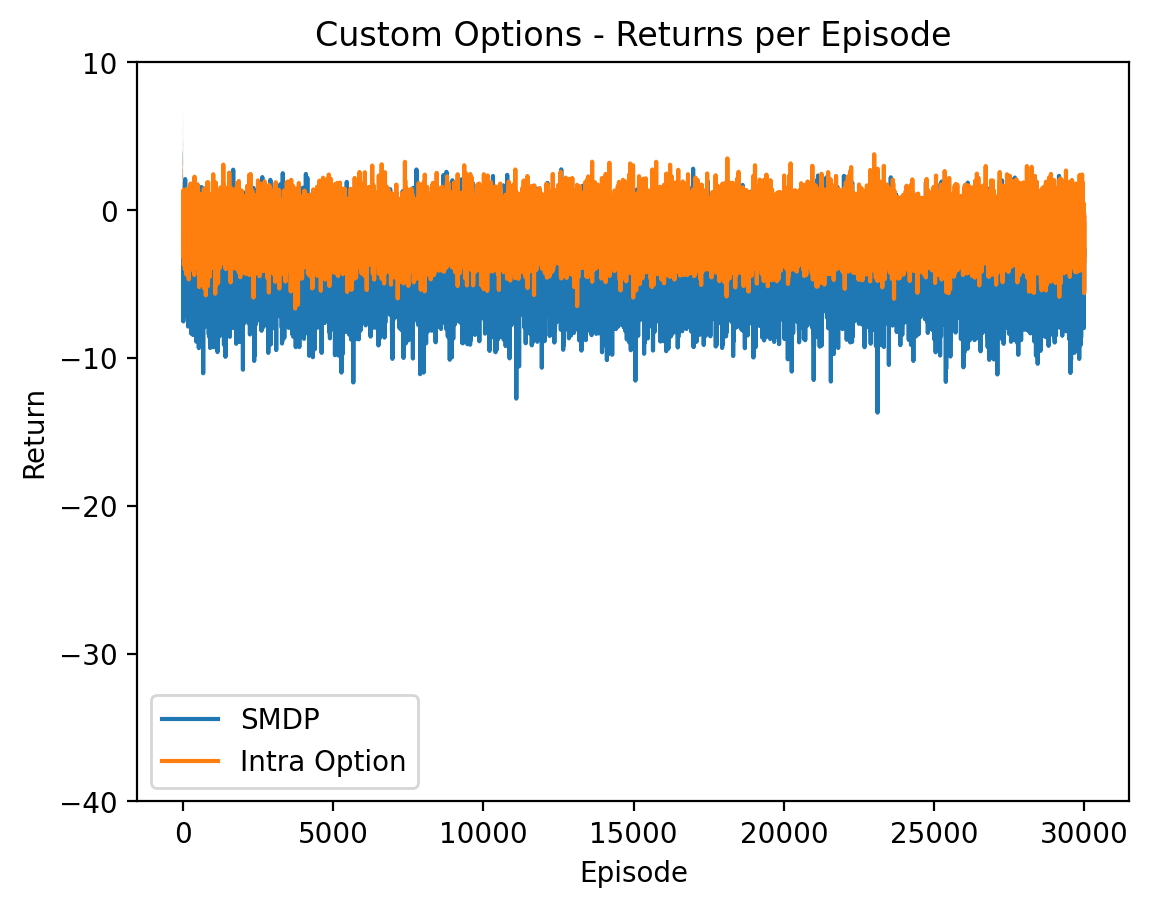

In [116]:
mean_data = np.mean(returns_SMDP, axis=0)
variance_data = np.var(returns_SMDP, axis=0)
shade_data_1ow = mean_data - np.sqrt(variance_data)
shade_data_high = mean_data + np.sqrt(variance_data)

plt.plot(mean_data, label='SMDP')
plt.fill_between(shade_data_1ow, shade_data_high, alpha=0.3)

mean_data = np.mean(returns_IO, axis=0)
variance_data = np.var(returns_IO, axis=0)
shade_data_1ow = mean_data - np.sqrt(variance_data)
shade_data_high = mean_data + np.sqrt(variance_data)

plt.plot(mean_data, label='Intra Option')
plt.fill_between(shade_data_1ow, shade_data_high, alpha=0.3)

plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return')
plt.ylim(-40,10)
plt.title(f'Custom Options - Returns per Episode')
plt.show()

In [88]:
seed = np.random.randint(1000)
state, _ = env.reset(seed=seed)
state_info = state2stateinfo(state)
print(f"Initial Taxi Location: {state_info[0],state_info[1]}, Passenger Location: {state_info[2]}, Destination Location: {state_info[3]}")
done = False
gamma = 0.9
total_return = 0
steps = 0
while not done:
    action = len(Q[state]) - 1 - np.argmax(np.flip(Q[state]))
    if action<num_actions:
        next_state, reward, done1, done2, _ = env.step(action)
        done = done1 or done2
        print(f"Taxi Location: {state2stateinfo(state)[0:2]}, Action: {actions[action]}, Reward: {reward}")
        state = next_state
        total_return += (gamma**steps) * reward
    else:
        optdone = False
        count = 0
        returns = 0
        start_state = state
        while not done:
            optact, optdone = option_handles[action-num_actions](state)
            if optdone and count!=0:
                break
            next_state, reward, done1, done2, _ = env.step(optact)
            done = done1 or done2
            returns += (gamma**count)*reward
            count += 1
            state = next_state
            
        total_return += (gamma**steps) * returns

        print(f"Taxi Location: {state2stateinfo(start_state)[0:2]}, Action: {actions[action]}, Reward: {returns}")
        
print(f"Total Returns: {total_return}")

Initial Taxi Location: (2, 3), Passenger Location: 2, Destination Location: 0
Taxi Location: [2, 3], Action: LEFT, Reward: -2.71
Taxi Location: [2, 0], Action: DOWN, Reward: -1.9
Taxi Location: [4, 0], Action: PICKUP, Reward: -1
Taxi Location: [4, 0], Action: NORTH, Reward: -1
Taxi Location: [3, 0], Action: UP, Reward: -2.71
Taxi Location: [0, 0], Action: DROP-OFF, Reward: 20
Total Returns: 10.68


In [89]:
def plot_Qmap_outer(Q):
    mpl.rcParams['figure.dpi'] = 200
    Qplot = np.zeros((5, 5), dtype=int)
    passenger_location = np.random.randint(0, 5)
    destination = np.random.randint(0, 4)
    while destination == passenger_location:
        destination = np.random.randint(0, 4)

    plt.title(
        f"Passenger = {passenger_locations[passenger_location]}, Destination = {destinations[destination]}, ")

    for i in range(5):
        for j in range(5):
            stateinfo = [i, j, passenger_location, destination]
            Qplot[i, j] = len(Q[stateinfo2state(stateinfo)]) - 1 - np.argmax(np.flip(Q[stateinfo2state(stateinfo)]))

    colors = []
    for i in actions:
        if i == "DOWN":
            colors.append((1, 0, 0))
        elif i == "UP":
            colors.append((0, 189/255, 0))
        elif i == "RIGHT":
            colors.append((0, 0, 1))
        elif i == "LEFT":
            colors.append((167/255, 201/255, 0))
        elif i == "PICKUP":
            colors.append((235/255,129/255,1))
        elif i == "DROP-OFF":
            colors.append((103/255,240/255,135/255))
        elif i == "SOUTH":
            colors.append((113/255,201/255,168/255))
        elif i == "NORTH":
            colors.append((193/255,172/255,86/255))
        elif i == "EAST":
            colors.append((193/255,172/255,86/255))
        elif i == "WEST":
            colors.append((193/255,86/255,86/255))
    if len(colors) == len(actions):
        cmap_custom = ListedColormap(colors)
        plt.imshow(Qplot, cmap=cmap_custom, vmin=0, vmax = len(actions)-1)
    else:
        plt.imshow(Qplot, cmap='viridis', vmin=0, vmax = len(actions)-1)


    for i in range(5):
        for j in range(5):
            text = plt.text(j, i, actions[Qplot[i, j]],
                            ha="center", va="center", color="w", size="xx-small")
    plt.show()


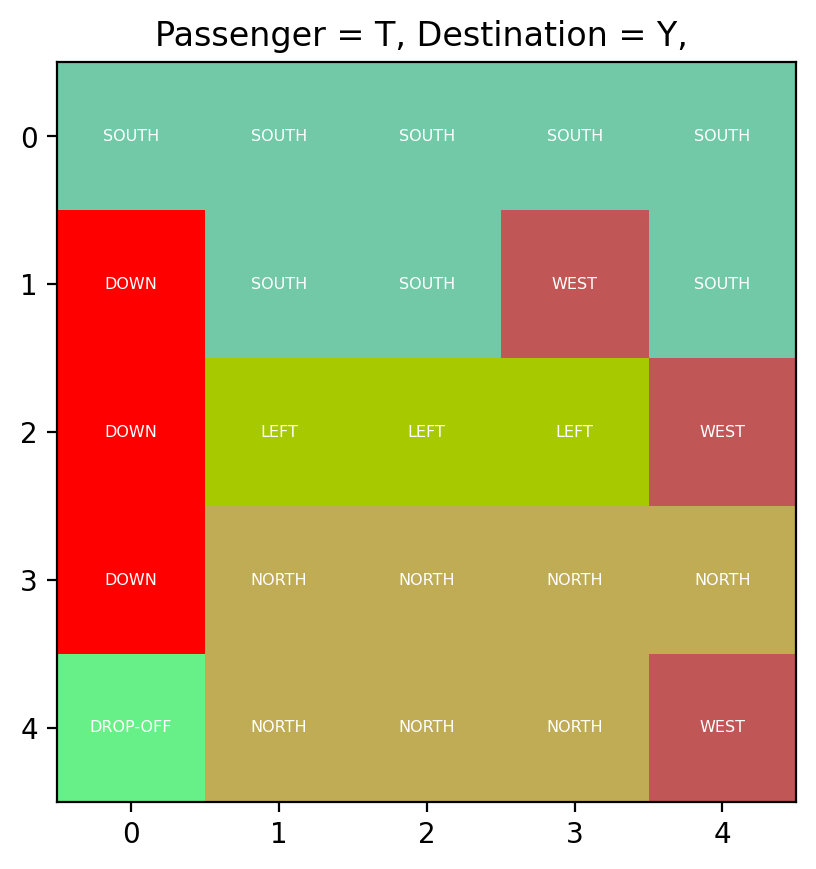

In [114]:
plot_Qmap_outer(Q_SMDP)

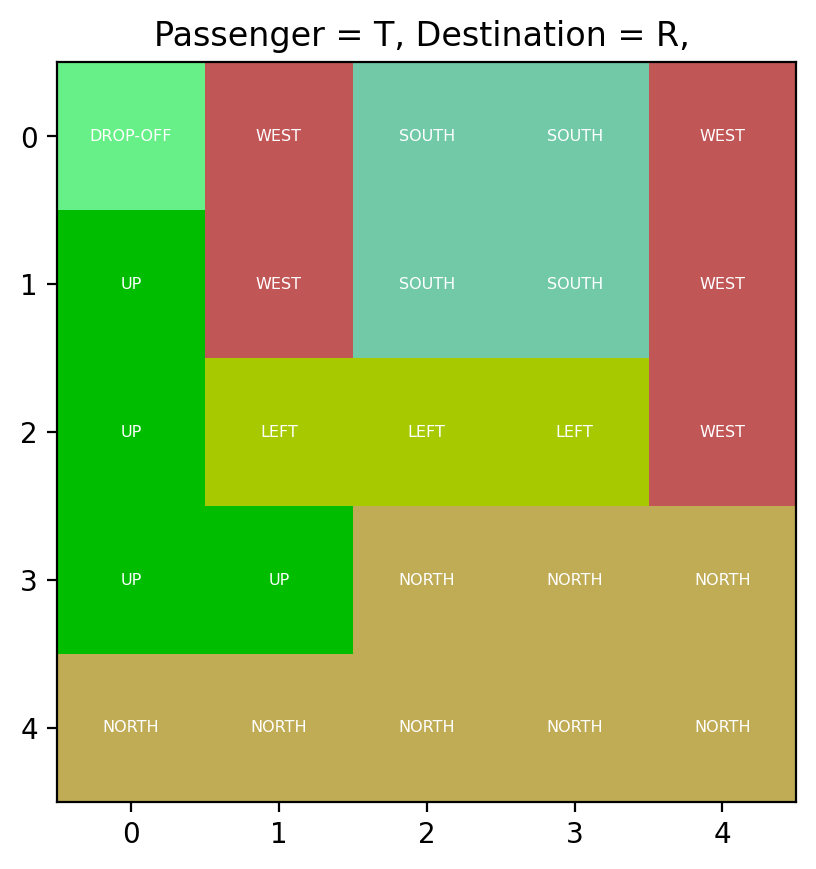

In [101]:
plot_Qmap_outer(Q_IO)